# This is a simple notebook to use Logistic Regression model for the Ising model.

It accompanies Chapter 5 of the book (4 of 5).

Copyright: Viviana Acquaviva (2023); see also other data credits below.

This notebook is modified by Gang Xu for PSI Scientific Machine Learning course. 

License: [BSD-3-clause](https://opensource.org/license/bsd-3-clause/)

## Import libraries <span style="color:blue"> (no need to change)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
from matplotlib import cm

In [2]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split

from sklearn.model_selection import KFold, StratifiedKFold

from sklearn import metrics

## We now see an example from Mehta et al 2018:

["A high-bias, low-variance introduction to Machine Learning for physicists"](https://arxiv.org/abs/1803.08823).

(Thank you to Pankaj Mehta and David Schwab)!

We are trying to use a logistic regression model to predict whether a material is in a ordered or disordered phase, based on its spin configuration. In an ordered phase, the spins are aligned. The representation is a 2D lattice so our features are the spin states of each element in the lattice. The physical model, known as Ising model, predicts that the transition depends on temperature and is smeared (for a finite-size lattice), around a critical temperature $T_c$.

The training data is composed of 160,000 Monte Carlo simulations in a range of temperatures, and their labels.

Possible applications of this formalism involve predicting the critical temperature for more complex systems.



### Reading in data (Reading in the data might take a little while.) <span style="color:blue"> (No need to change)

In [5]:
#This is gratefully borrowed with permission from the notebooks maintained by P. Mehta.

######### LOAD DATA
######### The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
data_file_name = '../../data/Ising2DFM_reSample_L40_T=All.pkl'
######### The labels are obtained from the following file:
label_file_name = '../../data/Ising2DFM_reSample_L40_T=All_labels.pkl'


############ DATA
with open(data_file_name, 'rb') as pickle_file:
#r=read b=binary pickle must be read in binary mode and needs to be open
# with... as... will automatically close the file after opening it is safer
    data = pickle.load(pickle_file) # pickle reads the file and returns the Python object (1D array, compressed bits) and store in data

#### Decompress array and reshape for convenience
data = np.unpackbits(data).reshape(-1, 1600)
#data has byte (8bits) unpackbits unpack it into 8 bits return a bunch of 0 and 1s
#-1: figure out how many rows there are, each row has 1600=40*40 bits The length of the lattice is 40
data=data.astype('int')
#now convert the datatype to integer

#### map 0 state to -1 (Ising variable can take values +/-1)
data[np.where(data==0)]=-1 
# np.where(data==0) find all indices where data is 0

###### READ LABELS (convention is 1 for ordered states and 0 for disordered states)
with open(label_file_name, 'rb') as pickle_file:
    labels = pickle.load(pickle_file) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)
print(data.shape) # the shape of the features
print(np.unique(labels)) # the unique labels

/var/folders/f1/t5kf_kd90jldsl110w3h81fw0000gn/T/ipykernel_53163/912722035.py:14: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  data = pickle.load(pickle_file) # pickle reads the file and returns the Python object (1D array, compressed bits) and store in data


(160000, 1600)
[0 1]


/var/folders/f1/t5kf_kd90jldsl110w3h81fw0000gn/T/ipykernel_53163/912722035.py:29: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  labels = pickle.load(pickle_file) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)


### Visualize the data: We can take a look at the label distribution. <span style="color:blue"> (no need to change)

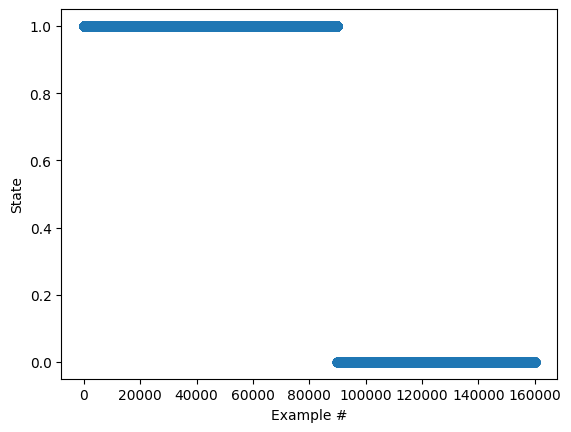

In [6]:
plt.scatter(np.arange(data.shape[0]),labels)
#data.shape[0]=160000

plt.xlabel('Example #')

plt.ylabel('State');

###labels: 1 = ordered or near-critical
###labels: 0 = disordered

### Write one-line code to tell if data is balanced or imbalanced here <span style="color:blue"> part a)

In [ ]:
#student write code here for part a)





### Visualize the spin configurations <span style="color:blue"> (Play with which data you want to look at, remember the data is not ordered from low temp to high temp)

<Figure size 1500x800 with 0 Axes>

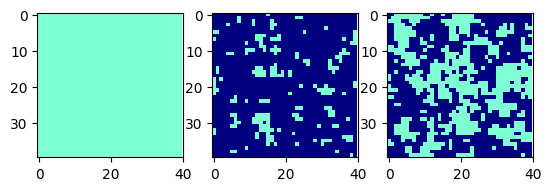

In [7]:
#H/T: https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale

cmap = matplotlib.colors.ListedColormap(["aquamarine","navy"], name='from_list', N=None)
#["aquamarine","navy"] list of color for each value
#name='from_list' optional name for the color list
#N=None  # optional number of entries (auto from list)
plt.figure(figsize=(15,8))
fig, axarr = plt.subplots(nrows=1, ncols=3)
axarr[0].imshow(data[0].reshape(40,40), cmap = cmap) #first object has label "1"
axarr[1].imshow(data[80000].reshape(40,40), cmap = cmap) #from documentation, this is critical-ish (between 60, and 90,000)
axarr[2].imshow(data[100000].reshape(40,40), cmap = cmap) #disordered
for i in range(3):
    axarr[i].set_xticks([0,20,40]);

### Let's pick a random selection (10%) to shuffle the data. <span style="color:blue"> (No need to change)

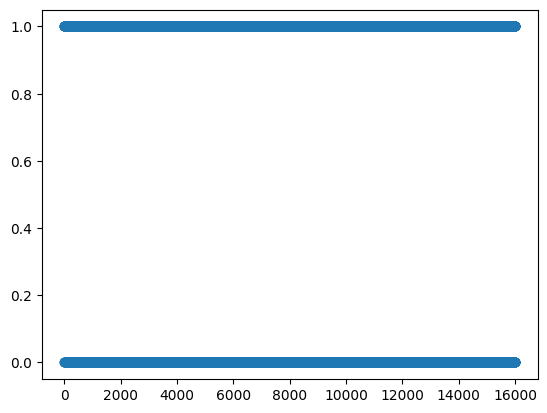

In [8]:
np.random.seed(228) #this random seed is carefully chosen so that one example is very special in the future

sel = np.random.choice(data.shape[0], data.shape[0]//10, replace = False)
#np.random.choice(
 #   a,         # range or array of values to choose from
  #  size,      # number of samples to pick
   # replace=False  # without replacement → no repeats
#)
seldata = data[sel,:] # for all indices, select all data
sellabels = labels[sel]
plt.scatter(np.arange(seldata.shape[0]),sellabels); #The random selection has the advantage of reshuffling the data!

### And now time for the logistic regression model. <span style="color:blue"> (No need to change, need a bit patience here)

In [9]:
###This uses a numerical method to find the minimum of the loss function
model = LogisticRegression(max_iter = 1000) 
###Takes up to 3 minutes
###We can use cross validation
results = cross_validate(model, seldata, sellabels, 
                         cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score = True)
print(results)

{'fit_time': array([0.86499929, 1.10459328, 0.51313996, 0.71166182, 1.58643913]), 'score_time': array([0.01148796, 0.00610399, 0.00631022, 0.00691605, 0.00797606]), 'test_score': array([0.6796875, 0.685625 , 0.68625  , 0.6853125, 0.6821875]), 'train_score': array([0.77984375, 0.78351563, 0.77726562, 0.77664062, 0.77773437])}


### What hyperparamters do we have to tune?<span style="color:blue"> (No need to change)

In [10]:
model.get_params()
#C inverse of regularization strength #all weights for classes are equal #dual false if samples>features.
#usually we want an intercept scaling is only used for a different solver
#l1ratio is used for other penalty #max_iter higher helps convergence #multi-class is auto#n_jobs use 1 core
#l2 regularization type #random state can be picked to reproduce result 
#lbfgs is an optimalization algorithm #tol small means more precise, slower
#verbose 0 means no progress print warm_start will reuse the previous solution as starting point

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': 0.0,
 'max_iter': 1000,
 'n_jobs': None,
 'penalty': 'deprecated',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Write a code to optimize the regularization parameter C:

In [ ]:
###Note that our data is already very regular (feature values are-1/1, so we are not doing any scaling).



### Here we generate the odds/probabilities in addition to labels in order to check predictions. <span style="color:blue"> (No need to change)

For those classifiers that are solving a regression problem under the hood, there is the handy "predict_proba" method. The output of predict_proba gives the probability to belong to disordered (label 0) or ordered (label 1) phase. The simple classifier output is the class with p > 0.5. We can look at this to convince ourselves:

In [ ]:
model = LogisticRegression(C=1.0, max_iter=1000)

ypred = cross_val_predict(model, seldata, sellabels, \
                               cv = KFold(n_splits=5, shuffle=True, random_state=10))

ypred_prob = cross_val_predict(model, seldata, sellabels, \
                               cv = KFold(n_splits=5, shuffle=True, random_state=10), method = 'predict_proba')
print(np.column_stack([ypred_prob, ypred]))

### We can plot a few examples to see how our classifier is doing. <span style="color:blue"> (No need to change)

In [ ]:
fig, axarr = plt.subplots(nrows=1, ncols=12, figsize=(20,5))
for i in range(12):
    axarr[i].imshow(seldata[i].reshape(40,40), cmap = cmap) 
    axarr[i].set_xlabel('True label:'+str(sellabels[i])+'\n'+'Pred label:'+str(ypred[i]))
    axarr[i].set_yticks([])
    axarr[i].set_xticks([])

### Take a look at the corresponding probabilities  <span style="color:blue"> (No need to change)

In [ ]:
ypred_prob[:12]